In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
weather = pd.read_csv('https://raw.githubusercontent.com/j-tice/capstone_final/a9b08f3c0f6fdd6e72bdd1465f3c6177b687d332/data/prepared_data/clean_data/clean_meteorological_data.csv?token=GHSAT0AAAAAAB6VFL53MLNJ3BDDDCBFB4EEY7W24LQ')
sensor = pd.read_csv('https://raw.githubusercontent.com/j-tice/capstone_final/a9b08f3c0f6fdd6e72bdd1465f3c6177b687d332/data/prepared_data/clean_data/clean_sensor_data.csv?token=GHSAT0AAAAAAB6VFL5377NMIJTI4FDPD5GUY7W26TA')
locations = pd.read_csv('https://raw.githubusercontent.com/j-tice/capstone_final/a9b08f3c0f6fdd6e72bdd1465f3c6177b687d332/data/prepared_data/clean_data/locations.csv?token=GHSAT0AAAAAAB6VFL52FIYH4HZSGI6NN6VEY7W27FA')
chem_counts = pd.read_csv('https://raw.githubusercontent.com/j-tice/capstone_final/a9b08f3c0f6fdd6e72bdd1465f3c6177b687d332/data/prepared_data/clean_data/chem_counts.csv?token=GHSAT0AAAAAAB6VFL53POOFCIIR4STI6BE4Y7W27SA')

psql = lambda q: sqldf(q, globals())

In [12]:
clean_locs = locations[locations.Name.str.contains('Sensor')]
clean_locs.columns = 'monitor,x,y'.split(',')
clean_locs.monitor = list(range(1,10))
clean_locs = clean_locs.reset_index().drop(['index'], axis='columns')
clean_locs

C:\Users\justi\AppData\Local\Temp\ipykernel_2820\3595248544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_locs.monitor = list(range(1,10))


,monitor,x,y
0,1,62,21
1,2,66,35
2,3,76,41
3,4,88,45
4,5,103,43
5,6,102,22
6,7,89,3
7,8,74,7
8,9,119,42


In [30]:
avg_dfs = dict()
chem_names = sorted(list(set(chem_counts.chemical)))

for name in chem_names:
    q = '''
        WITH base AS (
          SELECT Chemical, Monitor, AVG(Reading) AS avg_reading
          FROM sensor
          WHERE Chemical = "{chem}"
          GROUP BY Chemical, Monitor)  
        SELECT *
        FROM base LEFT JOIN clean_locs
        ON base.Monitor = clean_locs.monitor'''.format(chem=name)
    
    joined = psql(q)
    result = joined['Chemical,Monitor,x,y,avg_reading'.split(',')]
    result.columns = [elem.lower() for elem in result.columns]
    
    avg_dfs['d_{0}'.format(name)] = result

In [31]:
avg_dfs.keys()

dict_keys(['d_AGOC-3A', 'd_Appluimonia', 'd_Chlorodinine', 'd_Methylosmolene'])

In [32]:
avg_dfs['d_Appluimonia']

,chemical,monitor,x,y,avg_reading
0,Appluimonia,1,62,21,0.236594
1,Appluimonia,2,66,35,0.356967
2,Appluimonia,3,76,41,1.272462
3,Appluimonia,4,88,45,1.136383
4,Appluimonia,5,103,43,0.466799
5,Appluimonia,6,102,22,0.425051
6,Appluimonia,7,89,3,0.599914
7,Appluimonia,8,74,7,0.476935
8,Appluimonia,9,119,42,0.422416


C:\Users\justi\AppData\Local\Temp\ipykernel_2820\3007880510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['chemical'] = ['Factory'] * len(factories)
C:\Users\justi\AppData\Local\Temp\ipykernel_2820\3007880510.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['avg_reading'] = [1] * len(factories)


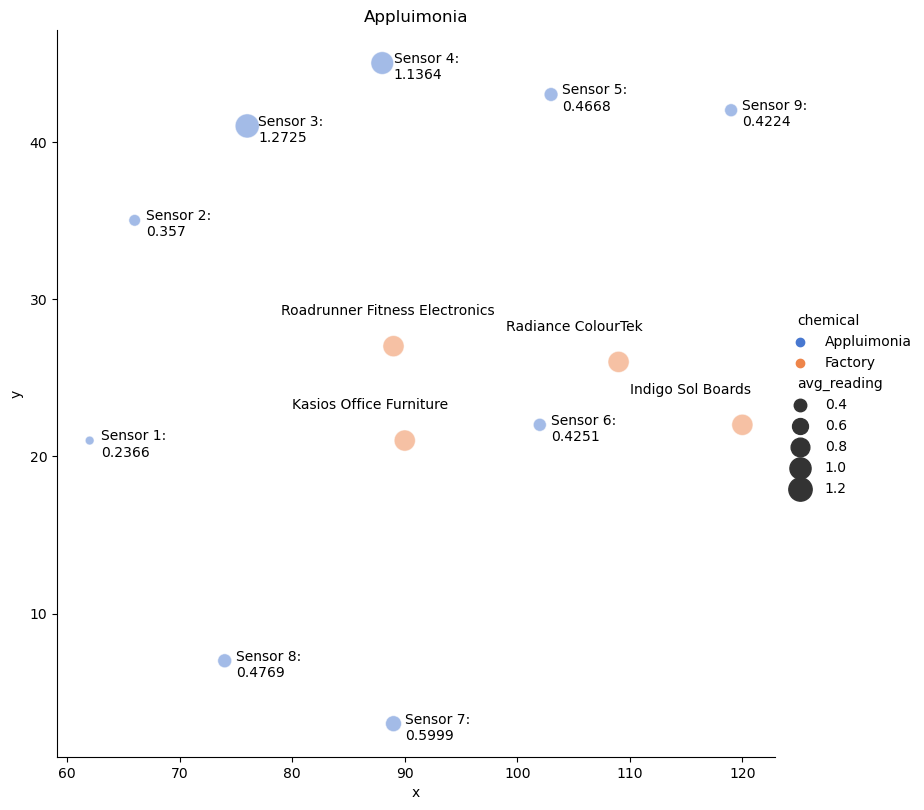

In [120]:
# test on one of them, say the one above
tmp = avg_dfs['d_Appluimonia']

factories = locations[~locations.Name.str.contains('Sensor')]
factories.columns = 'monitor,x,y'.split(',')
factories['chemical'] = ['Factory'] * len(factories)
factories['avg_reading'] = [1] * len(factories)
factories = factories['chemical,monitor,x,y,avg_reading'.split(',')]
total = pd.concat([tmp,factories])

bubbles = sns.relplot(
    x='x', y='y', 
    hue='chemical', palette='muted',
    size='avg_reading', sizes=(40, 300), 
    alpha=.5, height=8, 
    data=total
)
ax = bubbles.axes[0,0]
for idx,row in total.iterrows():
    x = row[2]
    y = row[3]
    text = row[1]
    label = 'Sensor ' + str(text) + ':\n{}'.format(round(row[4], 4)) if row[4] != 1 else text
    x_offset = x+1 if row[4] != 1 else x-10
    y_offset = y-1 if row[4] != 1 else y+2
    ax.text(x_offset, y_offset, label, horizontalalignment='left')
plt.title('Appluimonia')
plt.show(bubbles)

In [124]:
for elem in avg_dfs.values():
    print(elem.head(5))
    print()

  chemical  monitor    x   y  avg_reading
0  AGOC-3A        1   62  21     0.253239
1  AGOC-3A        2   66  35     0.424909
2  AGOC-3A        3   76  41     1.662681
3  AGOC-3A        4   88  45     1.506859
4  AGOC-3A        5  103  43     0.925276

      chemical  monitor    x   y  avg_reading
0  Appluimonia        1   62  21     0.236594
1  Appluimonia        2   66  35     0.356967
2  Appluimonia        3   76  41     1.272462
3  Appluimonia        4   88  45     1.136383
4  Appluimonia        5  103  43     0.466799

       chemical  monitor    x   y  avg_reading
0  Chlorodinine        1   62  21     0.250460
1  Chlorodinine        2   66  35     0.368848
2  Chlorodinine        3   76  41     1.298497
3  Chlorodinine        4   88  45     1.227665
4  Chlorodinine        5  103  43     0.508499

         chemical  monitor    x   y  avg_reading
0  Methylosmolene        1   62  21     0.244791
1  Methylosmolene        2   66  35     0.417800
2  Methylosmolene        3   76  41     

C:\Users\justi\AppData\Local\Temp\ipykernel_2820\2413040740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['chemical'] = ['Factory'] * len(factories)
C:\Users\justi\AppData\Local\Temp\ipykernel_2820\2413040740.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['avg_reading'] = [1] * len(factories)


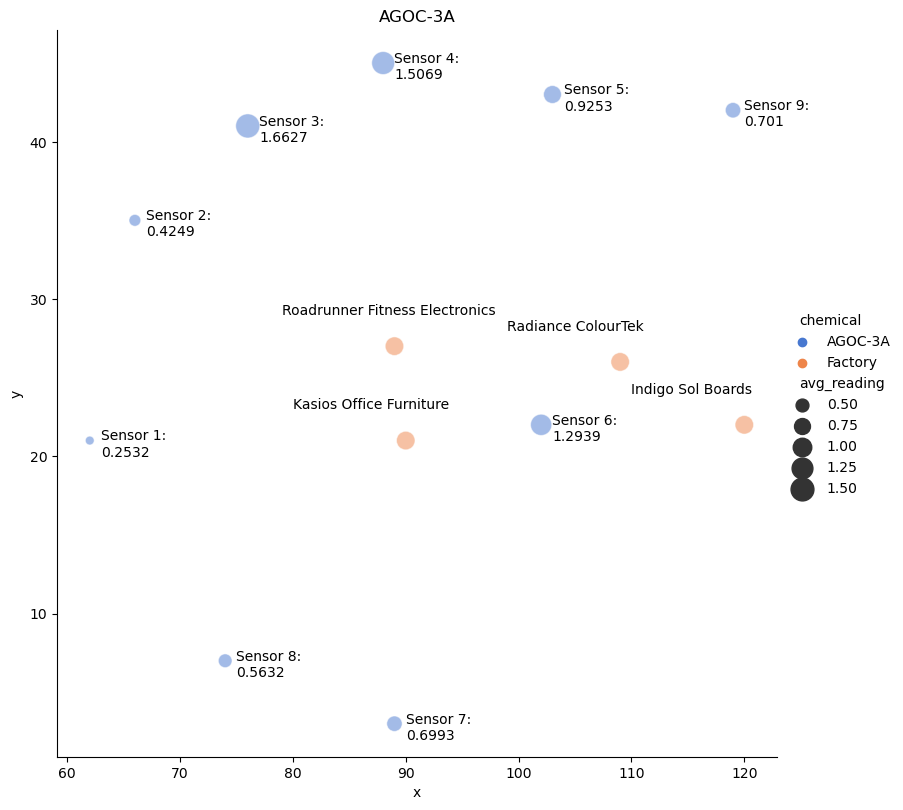

C:\Users\justi\AppData\Local\Temp\ipykernel_2820\2413040740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['chemical'] = ['Factory'] * len(factories)
C:\Users\justi\AppData\Local\Temp\ipykernel_2820\2413040740.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['avg_reading'] = [1] * len(factories)


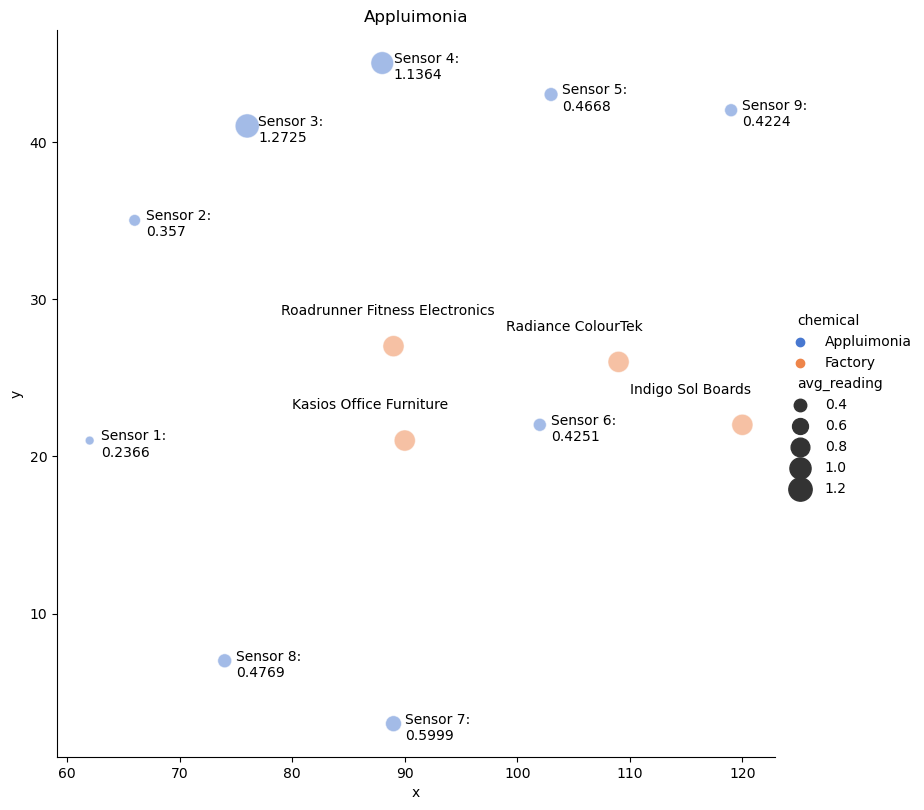

C:\Users\justi\AppData\Local\Temp\ipykernel_2820\2413040740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['chemical'] = ['Factory'] * len(factories)
C:\Users\justi\AppData\Local\Temp\ipykernel_2820\2413040740.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['avg_reading'] = [1] * len(factories)


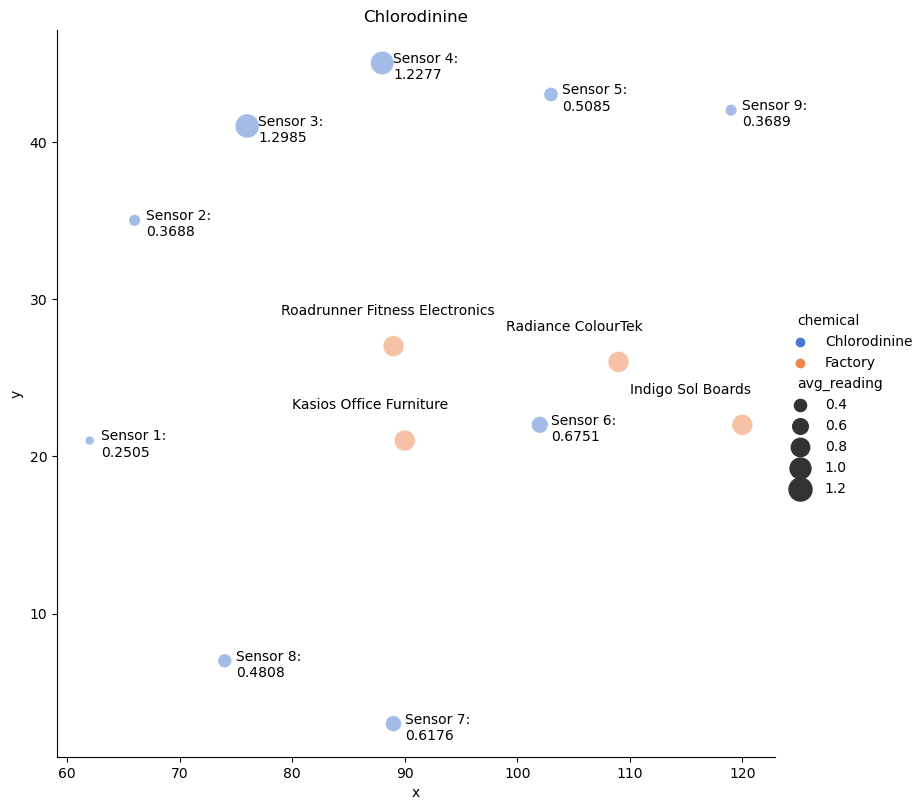

C:\Users\justi\AppData\Local\Temp\ipykernel_2820\2413040740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['chemical'] = ['Factory'] * len(factories)
C:\Users\justi\AppData\Local\Temp\ipykernel_2820\2413040740.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factories['avg_reading'] = [1] * len(factories)


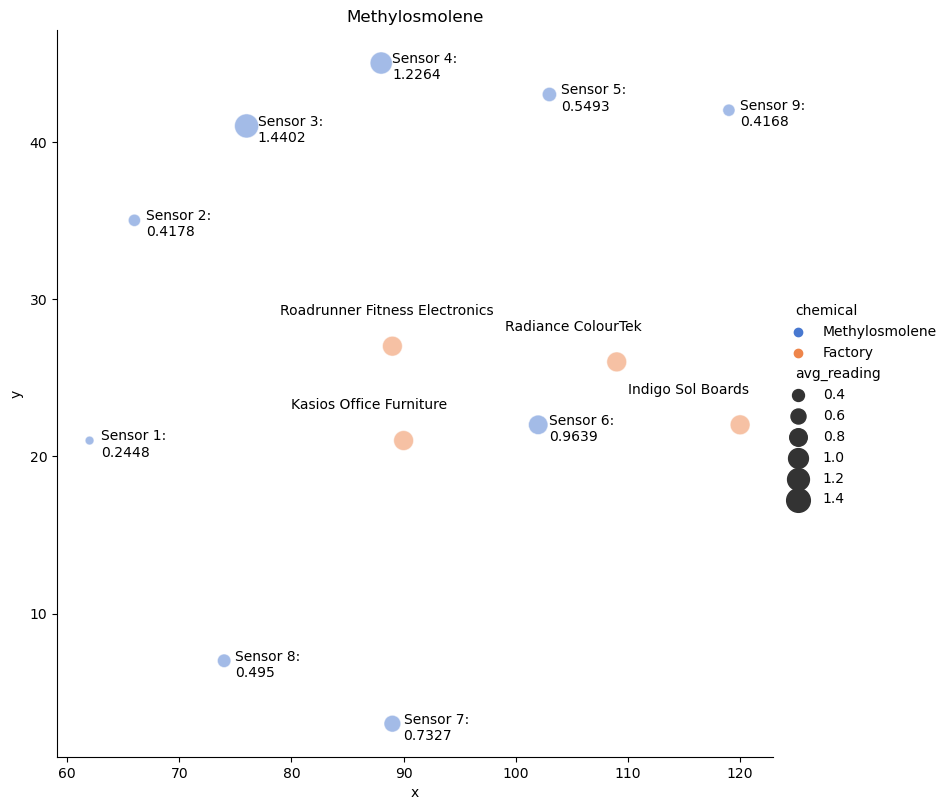

In [127]:
for df in avg_dfs.values():
    focus = df.chemical[0]
    
    tmp = df

    factories = locations[~locations.Name.str.contains('Sensor')]
    factories.columns = 'monitor,x,y'.split(',')
    factories['chemical'] = ['Factory'] * len(factories)
    factories['avg_reading'] = [1] * len(factories)
    factories = factories['chemical,monitor,x,y,avg_reading'.split(',')]
    total = pd.concat([tmp,factories])

    bubbles = sns.relplot(
        x='x', y='y', 
        hue='chemical', palette='muted',
        size='avg_reading', sizes=(40, 300), 
        alpha=.5, height=8, 
        data=total
    )
    ax = bubbles.axes[0,0]
    for idx,row in total.iterrows():
        x = row[2]
        y = row[3]
        text = row[1]
        label = 'Sensor ' + str(text) + ':\n{}'.format(round(row[4], 4)) if row[4] != 1 else text
        x_offset = x+1 if row[4] != 1 else x-10
        y_offset = y-1 if row[4] != 1 else y+2
        ax.text(x_offset, y_offset, label, horizontalalignment='left')
    plt.title(focus)
    
    plt.savefig('{}_avg_per_sensor'.format(focus.upper()))
    plt.show(bubbles)